In [1]:
import torch
import torchvision 
import torchvision.transforms as transforms 
import torchvision.models as models 
import torch.optim as optim 
import torch.nn as nn 
import torch.nn.functional as F

/nvme1/vchua/miniconda3/envs/timm-nncf/lib/python3.8/site-packages/tqdm-4.63.0-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import os
import numpy as np
import pandas as pd

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.colors

In [39]:
from collections import OrderedDict

In [59]:
def get_predicted_class_from_generalist(generalist_output):
    num_classes=100
    q_dist = torch.randn(num_classes, requires_grad = True, device = "cuda:0")
    
    optimizer = optim.Adam([q_dist], lr = 0.01)
    criterion = nn.KLDivLoss() 
  
    loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
    previous_loss = 10000.0
  
    niter = 0
    history = OrderedDict()
    
    while previous_loss > loss and loss > 1e-4: 
        previous_loss = loss 
        loss.backward(retain_graph = True)
        optimizer.step()
        optimizer.zero_grad()
        loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
        
        niter+=1
        if niter % 50 == 0:
            print("i: {:>4}, loss: {:.7f}".format(niter, loss))
            history[niter]=dict(logit=q_dist.detach().clone(), loss=loss.detach().clone())
            
    _, predicted = torch.max(q_dist.data, 0)
    return predicted, q_dist, history

In [60]:
def softmax(x, T=1):
    return np.exp(x/T)/sum(np.exp(x/T))

In [70]:
# uncommented different test vector for downstream visual inspection

# truth_logit = torch.tensor(
#     [-3.9590, -2.0515, -0.5774,  5.1484,  1.7667,  1.0344, -4.1960, -3.1156,
#          0.9609, -1.5631, -1.2940,  1.6504,  6.2300,  0.3255, -3.7318,  3.9184,
#         -2.7114, -0.8704, -3.1219,  3.8600,  0.8421, -0.2508, -3.3422, -2.1578,
#         -3.8930,  5.9081, -3.3247,  4.1585, -2.1461,  4.0722,  1.4414,  6.4662,
#          0.6407,  4.0227, -1.5072, -1.4641, -4.8978,  0.8196, -0.5129, -1.4389,
#          3.7711,  0.4063,  4.9503, -5.0868,  1.7623,  0.6425,  3.7870,  1.6573,
#         -1.4242, -0.5705, -1.9101, -2.4104,  2.4408, -5.3344, -4.3627,  2.0751,
#          1.2574, -3.0743,  2.8844,  3.2443, -1.2792, -4.4418, -2.7257,  2.5050,
#          0.3084,  1.1453,  1.1023,  0.1079,  2.0019,  0.0987, -3.7903,  1.3800,
#          2.5818,  1.0304,  0.5112,  1.8607,  3.4572, -4.0762, -2.6785, -1.8958,
#         -0.3501, -0.8199, -3.1478, -4.3716,  4.7555,  3.3035, -2.9216,  5.8537,
#         -3.4753,  1.2237,  1.7221, -4.3978, -1.6319, -1.0329,  1.7101,  0.7939,
#          1.1648, -0.7758,  1.3151, -1.9657],
#     device="cuda:0")


# truth_logit = torch.tensor(
#     [  -3.305595  , -0.67422634, -1.302785  , -2.5926425 ,  1.2228434 ,
#        -5.0193343 ,  5.3814335 , -0.18921994,  2.5516865 , -4.5532093 ,
#        -1.5651951 , -2.0974407 ,  0.73707604,  1.3962117 ,  0.89172167,
#        -1.8106222 , -4.8127084 , -1.8966833 ,  1.8723115 ,  1.5303646 ,
#        -1.3096858 , -4.388978  , -0.63591206, -1.5903337 ,  2.1164076 ,
#        -3.0444827 , 11.912977  , -0.63351643, -2.0435548 ,  4.7670465 ,
#        -3.6849527 ,  1.3108656 ,  1.511168  ,  3.3229148 ,  5.0122447 ,
#         1.1286854 , -3.9996278 , -0.35842234,  4.3194366 , -1.9490943 ,
#         0.371716  , -0.97600555,  0.34158987,  1.1849079 ,  3.3905349 ,
#         4.822474  ,  0.19572678,  0.9003227 ,  3.6833649 , -1.6967921 ,
#         1.9445447 ,  4.9482794 , -4.7829475 , -2.0348828 ,  4.8985434 ,
#        -5.4111767 ,  3.0887737 ,  0.58384633, -6.103254  , -0.4641073 ,
#        -3.2161694 , -0.03264782,  0.3265972 ,  1.0378302 , -0.70106965,
#         2.9411776 ,  3.0046537 , -1.8457135 , -3.0231876 , -1.5018703 ,
#        -1.4016893 , -4.5050335 , -2.1137068 , -0.76651347,  1.8345611 ,
#        -0.4193028 , -3.262468  ,  0.88115627,  3.164385  ,  7.608915  ,
#         2.7818131 , -1.2747409 ,  4.072071  , -1.4693694 ,  1.7440935 ,
#        -2.2072623 , -3.4855704 , -1.8379048 ,  2.163571  ,  1.6510196 ,
#        -6.182493  ,  2.3418474 , -2.0913122 ,  4.452844  , -4.237987  ,
#        -5.191817  ,  1.5693377 , -0.42767254, -0.4569406 ,  3.664391  ],
#     device="cuda:0")

truth_logit = torch.tensor(
    [-3.8498054e+00, -9.4726479e-01, -1.5122228e+00,  3.9377844e+00,
        2.1475670e+00, -6.1667431e-03, -2.8110102e-01,  1.3313231e+00,
       -9.7578669e-01, -1.8547498e+00, -3.8346648e-01,  2.4305930e+00,
       -4.7512817e-01, -1.4959357e+00,  2.0773749e+00, -1.8048137e+00,
       -1.3727061e+00, -9.3773401e-01,  2.7501035e+00, -1.5723644e-01,
       -2.6821051e+00, -1.1120512e+00, -1.3472846e+00,  2.9008479e+00,
       -3.3823726e+00,  1.6464822e+00,  7.3230225e-01,  2.3646235e+00,
       -1.3327978e+00,  1.8249947e+00, -3.3227694e-01, -5.1895911e-01,
       -6.1949646e-01,  2.8659182e+00,  4.9105620e+00, -1.2625673e+00,
        3.1795323e+00, -1.2463967e+00,  4.4303763e-01,  8.9150751e-01,
       -3.5780945e+00, -8.3299458e-01,  8.4258089e+00,  3.6339066e+00,
        2.2862272e+00, -1.2575915e-01, -2.5228086e-01, -3.7293978e+00,
       -1.1661668e+00, -1.7201641e-01,  6.1278591e+00, -2.2100782e+00,
       -3.0336361e+00, -5.7284961e+00, -3.5059881e+00,  1.4161146e+00,
       -4.2175055e-01, -3.1684229e+00, -3.3876579e+00, -2.8875191e-03,
       -4.0670519e+00, -2.2779996e+00, -4.4864912e+00,  2.6598768e+00,
        5.7062426e+00, -1.5424271e+00,  4.9695239e+00,  7.8147018e-01,
        4.0109825e-01, -2.4276135e+00, -4.2435055e+00, -3.4402421e+00,
        1.6705675e+00, -1.6497349e+00,  2.4800532e+00,  1.6465307e+00,
       -4.3449563e-01, -2.8663449e+00, -1.0340122e+00,  3.3193805e+00,
        4.9159217e+00,  1.8610116e+00, -3.1665668e+00, -9.1481507e-01,
       -2.5371952e+00, -2.5091216e-01, -9.8793620e-01,  3.7677488e-01,
        5.4920135e+00, -7.2161949e-01,  2.4901400e+00, -2.0102017e+00,
       -4.7961110e-01, -6.2898123e-01, -3.4061360e-01, -2.3023808e+00,
        2.5142040e+00,  5.5886431e+00, -4.3568999e-01, -7.4481696e-01],
    device="cuda:0")
    

In [71]:
predicted, q_dist, history = get_predicted_class_from_generalist(truth_logit)

/tmp/ipykernel_55684/3785340604.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
/tmp/ipykernel_55684/3785340604.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
/tmp/ipykernel_55684/3785340604.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
/tmp/ipykernel_55684/3785340604.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))


i:   50, loss: 0.0268131
i:  100, loss: 0.0198487
i:  150, loss: 0.0139949
i:  200, loss: 0.0092095
i:  250, loss: 0.0057183
i:  300, loss: 0.0035480
i:  350, loss: 0.0023205
i:  400, loss: 0.0016203
i:  450, loss: 0.0011966
i:  500, loss: 0.0009232
i:  550, loss: 0.0007367
i:  600, loss: 0.0006034
i:  650, loss: 0.0005047
i:  700, loss: 0.0004292
i:  750, loss: 0.0003700
i:  800, loss: 0.0003227
i:  850, loss: 0.0002841
i:  900, loss: 0.0002522
i:  950, loss: 0.0002255
i: 1000, loss: 0.0002029
i: 1050, loss: 0.0001835
i: 1100, loss: 0.0001668
i: 1150, loss: 0.0001522
i: 1200, loss: 0.0001395
i: 1250, loss: 0.0001283
i: 1300, loss: 0.0001183
i: 1350, loss: 0.0001095
i: 1400, loss: 0.0001015


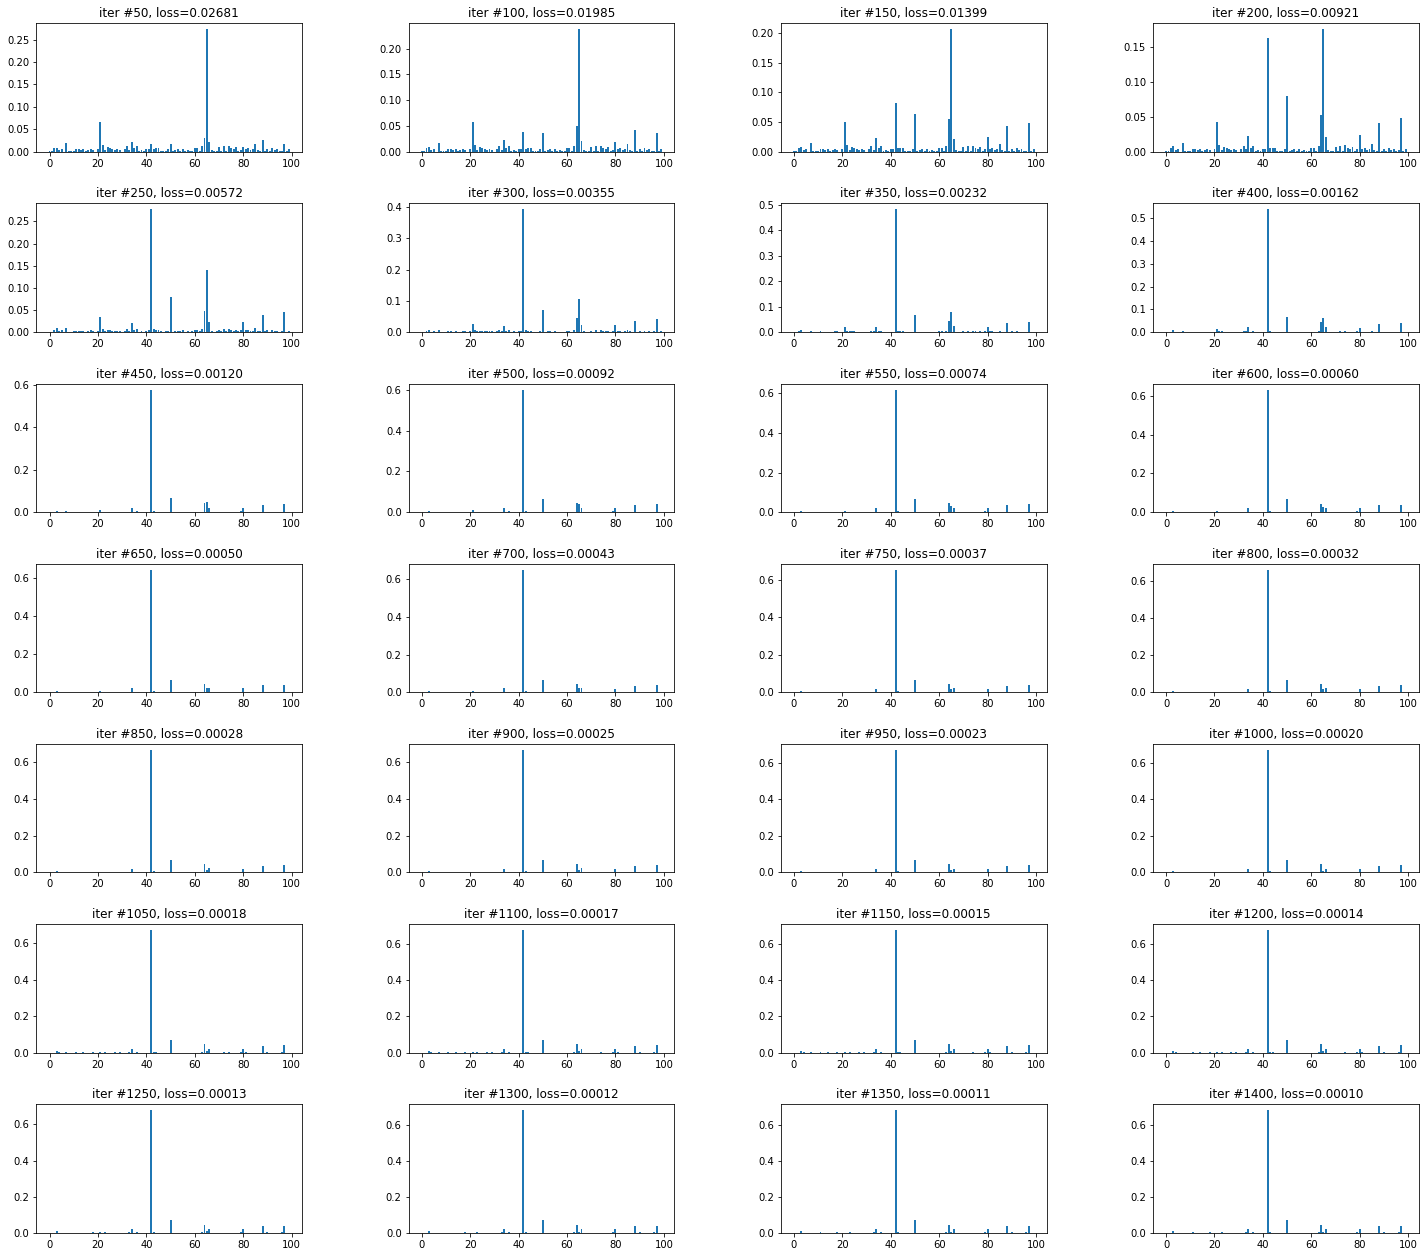

In [72]:
ncol=4
nrow=len(history)//ncol

if len(history) % ncol > 0:
    nrow += 1

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*6, nrow*3))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

for i, (niter, history_dict) in enumerate(history.items()):
    loss=history_dict['loss']
    q_logit=history_dict['logit']
    
    r=i//ncol
    c=i%ncol
    
    axes[r,c].bar(np.arange(q_logit.shape[0]), softmax(q_logit.detach().cpu().numpy()))
    axes[r,c].set_title("iter #{}, loss={:0.5f}".format(niter, loss))
    

Text(0.5, 1.0, 'Truth Distribution')

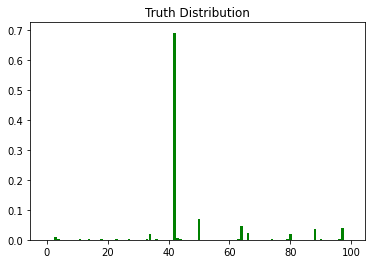

In [73]:
plt.bar(np.arange(truth_logit.shape[0]), softmax(truth_logit.cpu().numpy()), color='green')
plt.title("Truth Distribution")

Todo: Debug for ensemble case

Setup: as simple as possible, take the generalist and one specialist

get logit for both of them, plot them out.

follow the above method to plot the detail of emsemble optimization (different from the above, since the above only cater for reference logit), this may uncover if anything didnt behave correctly